<a href="https://colab.research.google.com/github/gchaudhuri/testwebpage/blob/main/wtp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("drive/MyDrive/from_nathan/Data and Code_Brynjolfsson_Eggers_Gannamaneni/Data and Code/Data.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Category,User ID,E,Accept_E
0,Wikipedia,1002202083,1,1
1,Wikipedia,1012015229,1,0
2,Wikipedia,101305686,1,0
3,Wikipedia,1018176924,1,1
4,Wikipedia,1024612669,1,0


In [4]:
print(df.dtypes)
print(df.count) # number of rows

Category    object
User ID      int64
E            int64
Accept_E     int64
dtype: object
<bound method DataFrame.count of        Category     User ID      E  Accept_E
0     Wikipedia  1002202083      1         1
1     Wikipedia  1012015229      1         0
2     Wikipedia   101305686      1         0
3     Wikipedia  1018176924      1         1
4     Wikipedia  1024612669      1         0
...         ...         ...    ...       ...
8509  Wikipedia   981844036  50000         0
8510  Wikipedia   986385267  50000         0
8511  Wikipedia   987992969  50000         1
8512  Wikipedia   997419601  50000         0
8513  Wikipedia   997938626  50000         1

[8514 rows x 4 columns]>


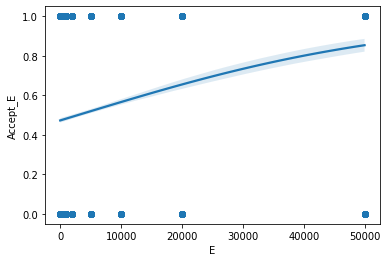

In [5]:
sns.regplot(x = df['E'], y = df['Accept_E'], data = df, logistic=True, ci=95) # confidence interval none.
plt.show()

In [6]:
# Setting up data

x = np.log(df['E'])
y = 1-df['Accept_E']

In [7]:
## Running logit model 

from statsmodels.formula.api import logit

np.random.seed(1)

formula_wtp = ('y ~ x')
model = logit(formula=formula_wtp, data = df).fit()
model.summary() # results match with Eggers original results

Optimization terminated successfully.
         Current function value: 0.644479
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8514
Model:                          Logit   Df Residuals:                     8512
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Aug 2022   Pseudo R-squ.:                 0.06951
Time:                        04:11:57   Log-Likelihood:                -5487.1
converged:                       True   LL-Null:                       -5897.0
Covariance Type:            nonrobust   LLR p-value:                2.717e-180
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1517      0.050     23.145      0.000       1.054       1.249
x             -0.2298      0.009    -26.983      0.000      -0.247      -0.213
==============================================================================
"""

In [8]:
# odds ratio
print(np.exp(model.params))

# average marginal effects (ame)
ame=model.get_margeff(at='overall', method='dydx')
print(ame.summary())

Intercept    3.163434
x            0.794679
dtype: float64
        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.0521      0.002    -32.691      0.000      -0.055      -0.049


In [9]:
def median_wta(model):
 median_wta = -model.params[0]/model.params[1]
 return median_wta

In [10]:
 blogit0 = logit(formula=formula_wtp, data = df).fit()

Optimization terminated successfully.
         Current function value: 0.644479
         Iterations 5


In [11]:
wta_blogit0 = median_wta(blogit0)
print(wta_blogit0)

5.011205597161743


In [12]:
# WTA
np.exp(wta_blogit0)

150.0855698578799

In [22]:
blogit_orig_coef = pd.DataFrame(columns=['Intercept', 'X Coef'])
blogit_orig_wta = pd.DataFrame(columns=['WTA'])

blogit0 = logit(formula=formula_wtp, data = df).fit()# in R code its just model not fit
blogit_orig_coef = blogit_orig_coef.append({'Intercept':  blogit0.params[0], 'X Coef': blogit0.params[1]}, ignore_index=True)
wta_blogit0 = median_wta(blogit0)
blogit_orig_wta = blogit_orig_wta.append({'WTA':  wta_blogit0}, ignore_index=True)
orig_result = pd.concat([blogit_orig_wta, blogit_orig_coef], axis=1)
print('Original Result:', orig_result)

Optimization terminated successfully.
         Current function value: 0.644479
         Iterations 5
Original Result:         WTA  Intercept    X Coef
0  5.011206   1.151658 -0.229817


In [ ]:
from statsmodels.formula.api import logit
from sklearn.utils import resample

boot_sample = resample(df, replace=True, n_samples=1000, random_state=1)
boot_sample.info

In [14]:
blogit0_result =  np.vstack((wta_blogit0, blogit0.params[0], blogit0.params[1]))
print('\n wta intercept:', blogit0_result[0], 
      '\n model intercept:', blogit0_result[1], 
      '\n x coef:', blogit0_result[2])


 wta intercept: [5.0112056] 
 model intercept: [1.15165828] 
 x coef: [-0.22981661]


In [ ]:
from operator import truediv
blogit_boot_coef = pd.DataFrame(columns=['Intercept', 'X Coef'])
blogit_boot_wta = pd.DataFrame(columns=['WTA'])

n_iterations = 1000  #No. of bootstrap samples to be repeated (created)
n_size = 1000

draws = 1000
for i in range(draws):
  boot_sample = df.sample(n=df.shape[0], replace=True) 
  y_boot = 1-boot_sample['Accept_E']
  x_boot = np.log(boot_sample['E'])
  formula_boot = 'y_boot ~ x_boot' 
  blogit_boot = logit(formula=formula_boot, data = boot_sample).fit()
  blogit_boot_coef = blogit_boot_coef.append({'Intercept':  blogit_boot.params[0], 'X Coef': blogit_boot.params[1]}, ignore_index=True)
  wta_boot = median_wta(blogit_boot)
  blogit_boot_wta = blogit_boot_wta.append({'WTA':  wta_boot}, ignore_index=True)

boot_result = pd.concat([blogit_boot_wta, blogit_boot_coef], axis=1)


In [ ]:
boot_result.head()

In [77]:
from pandas.core.dtypes.cast import astype_array
boot_result_mean = boot_result.mean(axis = 0, skipna = True)
print(boot_result_mean)
boot_result_sd = boot_result.std(axis = 0, skipna = True)
print(boot_result_sd)

bias = orig_result - boot_result_mean
print(bias)

ci_WTA = pd.DataFrame()
ci95_hi_wta = boot_result_mean.iloc[0] + 1.96* boot_result_sd.iloc[0]
ci95_lo_wta = boot_result_mean.iloc[0] - 1.96* boot_result_sd.iloc[0]
ci_WTA = ci_WTA.assign(hi=np.array(ci95_hi_wta)) not working
ci_WTA = ci_WTA.assign(lo=np.array(ci95_lo_wta))
print('WTA CI 95%:', ci95_hi_wta, ci95_lo_wta)
print(ci_WTA)

WTA          5.007723
Intercept    1.150656
X Coef      -0.229767
dtype: float64
WTA          0.098130
Intercept    0.049911
X Coef       0.008670
dtype: float64
        WTA  Intercept    X Coef
0  0.003483   0.001003 -0.000049
WTA CI 95%: 5.2000570855152235 4.815388034919761
Empty DataFrame
Columns: [hi, lo]
Index: []


In [62]:

type(ci95_lo_wta)
ci_WTA = []
ci_WTA = ci_WTA.append(ci95_hi_wta.tolist)
ci_WTA = ci_WTA.append(ci95_lo_wta.tolist)
print(ci_WTA)
#ci_WTA = np.concatenate((ci95_hi_wta, ci95_lo_wta))

AttributeError: ignored

In [ ]:
from statsmodels.formula.api import logit
from sklearn.utils import resample

blogit_orig_coef = pd.DataFrame(columns=['Intercept', 'X Coef'])
blogit_orig_wta = pd.DataFrame(columns=['WTA'])
blogit_boot_coef = pd.DataFrame(columns=['Intercept', 'X Coef'])
blogit_boot_wta = pd.DataFrame(columns=['WTA'])

def bootstrap_model(draws, data, formula):
    # original solution
  blogit0 = logit(formula=formula_wtp, data = df).fit()# in R code its just model not fit
  blogit_orig_coef = blogit_orig_coef.append({'Intercept':  blogit0.params[0], 'X Coef': blogit0.params[1]}, ignore_index=True)
  wta_blogit0 = median_wta(blogit0)
  blogit_orig_wta = blogit_orig_wta.append({'WTA':  wta_blogit0}, ignore_index=True)
  orig_result = pd.concat([blogit_orig_wta, blogit_orig_coef], axis=1)
  print('Original Result:', orig_result)
  
  for i in range(draws):
    boot_sample = df.sample(n=df.shape[0], replace=True)
    y_boot = 1-boot_sample['Accept_E']
    x_boot = np.log(boot_sample['E'])
    formula_boot = 'y_boot ~ x_boot' 
    blogit_boot = logit(formula=formula_boot, data = boot_sample).fit()
    blogit_boot_coef = blogit_boot_coef.append({'Intercept':  blogit_boot.params[0], 'X Coef': blogit_boot.params[1]}, ignore_index=True)
    wta_boot = median_wta(blogit_boot)
    blogit_boot_wta = blogit_boot_wta.append({'WTA':  wta_boot}, ignore_index=True)

  boot_result = pd.concat([blogit_boot_wta, blogit_boot_coef], axis=1)
  boot_result_mean = boot_result.mean(axis = 0, skipna = True)
  boot_result_sd = boot_result.std(axis = 0, skipna = True)
  bias = orig_result - boot_result_mean
  ci_WTA <- c(boot.result.mean[1] - 1.96 * boot.result.sd[1], boot.result.mean[1] + 1.96 * boot.result.sd[1])
  
  lst <- list(boot = boot.result, bias = bias, sd = boot.result.sd, CI = ci_WTA, orig = orig.result)
  return(lst)
}
